# Notebook traduit en français d'après celui du cours "Deep Learning" d'Alfredo Canziani de la New York University  : 
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/07-listening_to_kernels.ipynb

# La convolution comme "produit scalaire".

Compte tenu des hypothèses de localité, de stationnarité et de composition, nous pouvons réduire la quantité de calcul pour une multiplication matrice-vecteur en utilisant un schéma Toeplitz/diagonale constante (parce que local) épars (parce que stationnaire).
De cette façon, nous finissons simplement par redécouvrir l'opérateur de convolution.

Nous rappelons également qu'un produit scalaire est simplement une distance en cosinus non normalisée, qui nous indique l'*alignement* de deux vecteurs.
Plus précisément, nous calculons la magnitude de la projection orthogonale d'un vecteur sur l'autre, ou *vice versa*.

In [1]:
# Utilisons une librairie pour la lecture audio :
import librosa

In [2]:
# Mon signal d'entrée x == x[k], échantillonnage du réel, temps continu, x(t)
x, sampling_rate = librosa.load('./res/win_xp_shutdown.wav')

In [3]:
# Calcule la durée temporelle de x(t)
T = x.size / sampling_rate
print(
    f'x[k] has {x.size} samples',
    f'the sampling rate is {sampling_rate * 1e-3}kHz',
    f'x(t) is {T:.1f}s long'
    , sep='\n')

x[k] has 70641 samples
the sampling rate is 22.05kHz
x(t) is 3.2s long


In [4]:
# Chargement de la visualisation interactive...
from res.plot_lib import set_default
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# ... dans 2 cellules 
set_default(figsize=(16, 8))

In [6]:
# Créer une période de temps x(t) 
dt = 1 / sampling_rate
t = np.r_[0:T:dt]

Essayez de zoomer, dans le graphique suivant, et voyez de très près à quoi ressemble la forme d'onde !

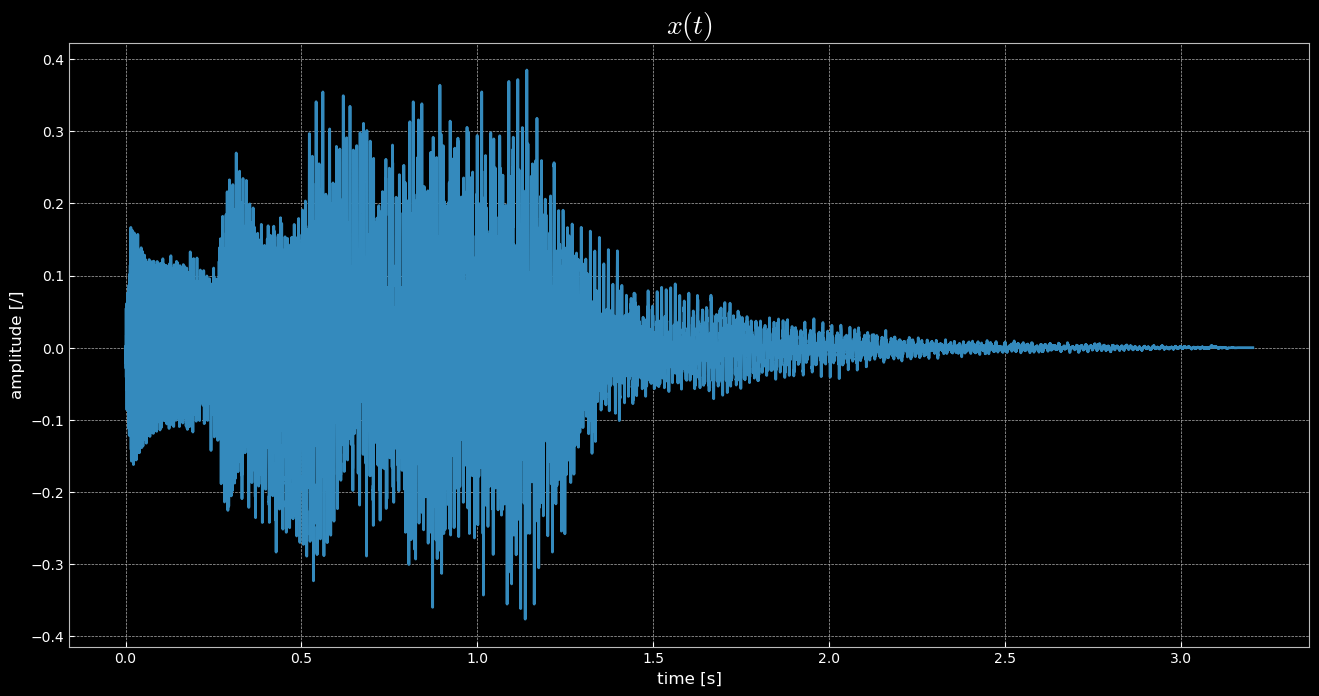

In [7]:
# Visualiser x(t)
plt.figure()
plt.plot(t, x)
plt.xlabel('time [s]')
plt.ylabel('amplitude [/]')
plt.title(r'$x(t)$', size=20);

In [8]:
# Importation des utilitaires Jupyter pour la lecture audio
from IPython.display import display, Audio

In [9]:
# Ecoutons x(t)
Audio(x, rate=sampling_rate)

![score](res/score.png)

In [10]:
## Calcule la transformée de Fourier à court terme (STFT pour Short-time Fourier transform) et converti l'amplitude en dB
X = librosa.stft(x)
X_dB = librosa.amplitude_to_db(np.abs(X))

In [11]:
# Importer la fonction spectroscope...
from librosa.display import specshow

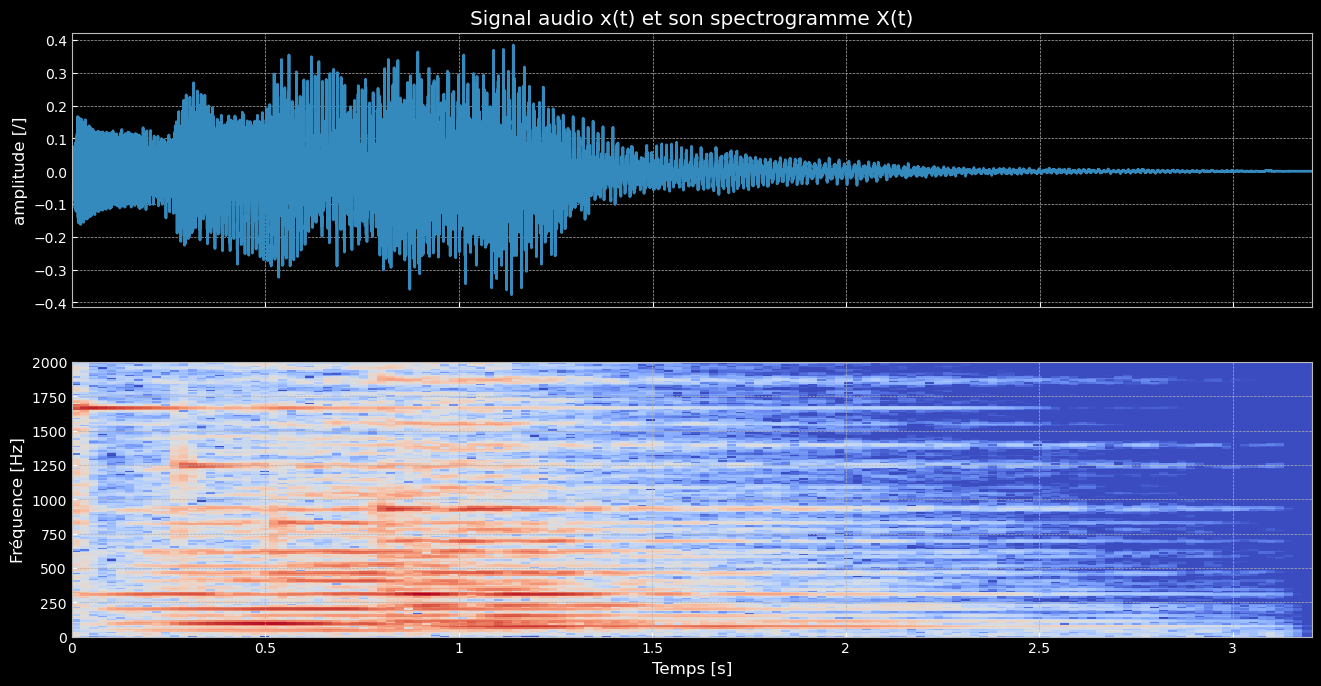

In [13]:
# ... et on visualise
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, x)
plt.xlim([0, T])
plt.ylabel('amplitude [/]')
plt.title('Signal audio x(t) et son spectrogramme X(t)')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.subplot(2,1,2)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.xlabel('Temps [s]')
plt.ylabel('Fréquence [Hz]')
plt.ylim(top=2000)
plt.grid(True)

In [14]:
# Reconstruction manuelle de la mélodie :
# choisir les fréquences/notes de la mélodie dans le spectrogramme ci-dessus
Ab6 = 1661  # Hz
Eb6 = 1244  # Hz
Ab5 = 830   # Hz
Bb5 = 932   # Hz
TT = .4  # s
tt = np.r_[0:TT:dt]

# générons des tonalités
A = {
    'a^(1)': np.sin(2 * np.pi * Ab6 * tt),
    'a^(2)': np.sin(2 * np.pi * Eb6 * tt),
    'a^(3)': np.sin(2 * np.pi * Ab5 * tt),
    'a^(4)': np.sin(2 * np.pi * Bb5 * tt),
}

# et concaténons les
xx = np.concatenate([a[1] for a in A.items()])

In [15]:
# Écoutons l'original et la reconstitution
display(Audio(x, rate=sampling_rate))
display(Audio(xx, rate=sampling_rate))

In [16]:
# Calculons le STFT de la reconstruction
XX = librosa.stft(xx)
XX_dB = librosa.amplitude_to_db(np.abs(XX))

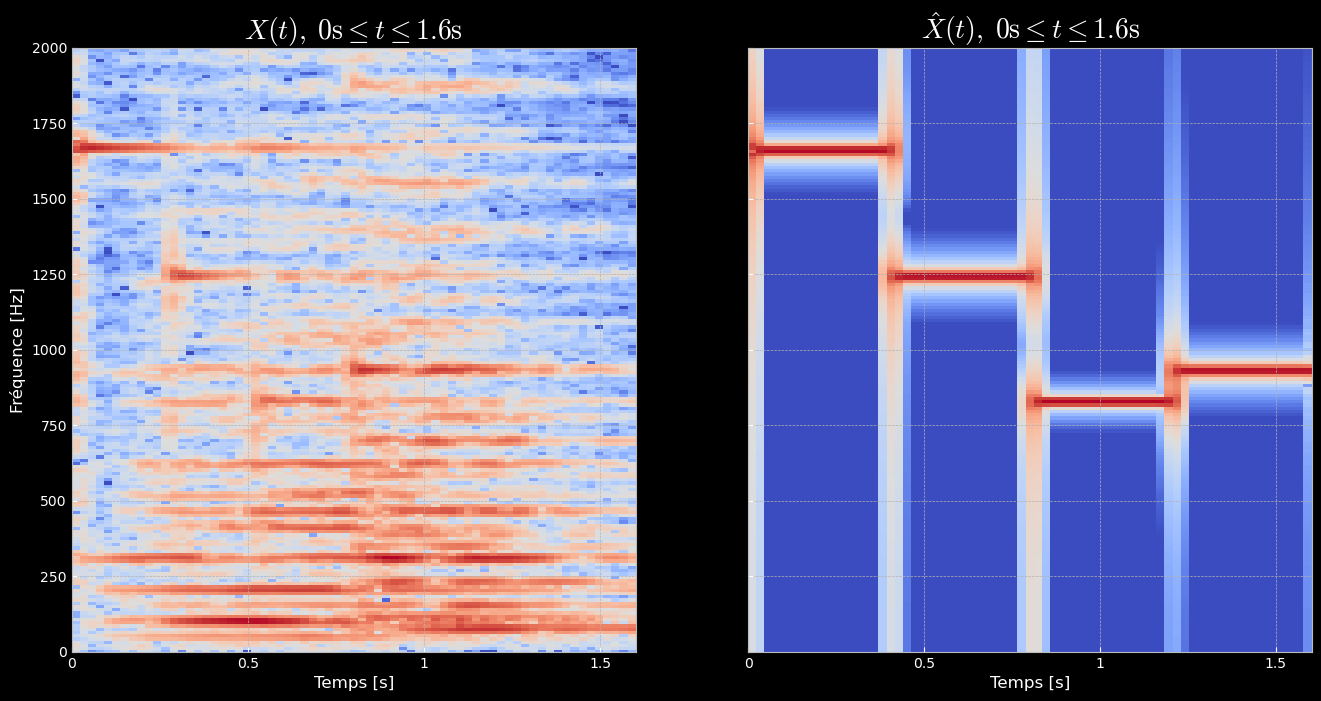

In [18]:
# ... et affichons X(t) et XX(t)
plt.figure()
t_string = r'$0\mathrm{s} \leq t \leq 1.6\mathrm{s}$'

plt.subplot(1,2,1)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.ylim(ymax=2000)
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.grid(True)
plt.xlim(right=1.6)
plt.title(r'$X(t),\; $' + t_string, size=20)

plt.subplot(1,2,2)
specshow(XX_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.xlabel('Temps [s]')
plt.ylim(top=2000)
plt.ylabel('')
plt.grid(True)
plt.title(r'$\hat X(t),\; $' + t_string, size=20);

Text(0.5, 0, 'Echantillon [/]')

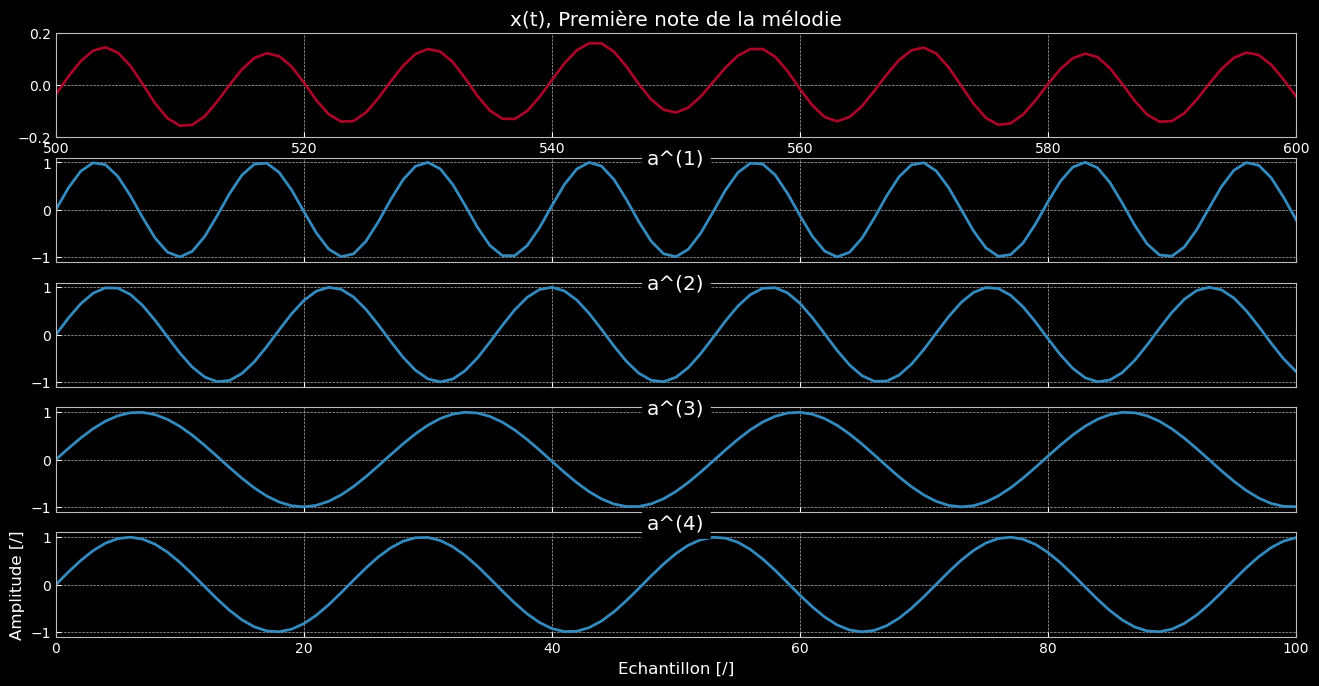

In [19]:
# Quand est il dans le domaine temporel ? Traçons x(t) et a^(i)(t)
plt.figure()
plt.subplot(5, 1, 1)
plt.title('x(t), Première note de la mélodie')
plt.plot(x, 'C1')
plt.xlim([500, 600])
plt.ylim([-.2, .2])
i = 2
for a in A.items():
    plt.subplot(5, 1, i)
    i += 1
    plt.plot(a[1])
    plt.xlim([0, 100])
    plt.title(a[0], verticalalignment='top', backgroundcolor='black')
    if i < 6: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)

plt.ylabel('Amplitude [/]')
plt.xlabel('Echantillon [/]')

Text(0.5, 0, 'Temps [s]')

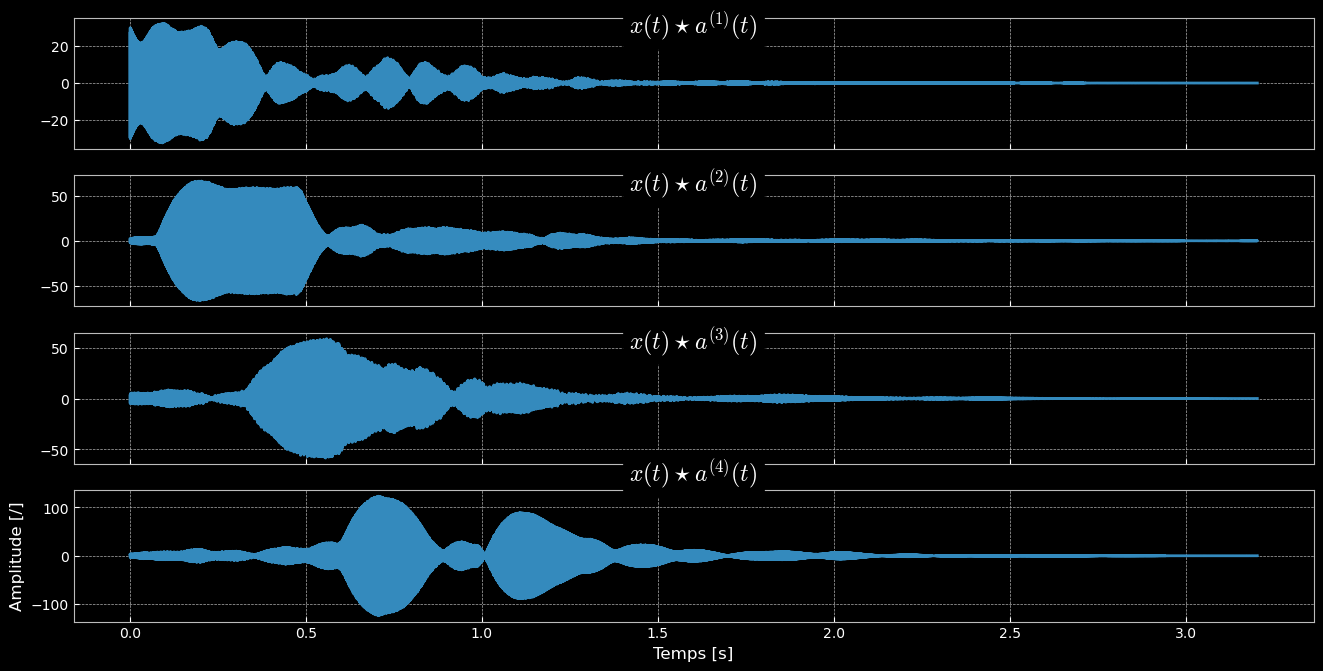

In [20]:
# Enfin, faisons la convolution de chaque a^(i) avec x(t)
plt.figure()
convs = list()
n = 1
for a in A.items():
    plt.subplot(4, 1, n)
    plt.title(rf'$x(t) \star a^{{({n})}}(t)$', backgroundcolor='black', verticalalignment='top', size=17)
    n += 1
    convs.append(np.convolve(x, a[1], mode='same'))
    plt.plot(t, convs[-1])
    if n < 5: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.ylabel('Amplitude [/]')
plt.xlabel('Temps [s]')

In [21]:
# Enfin, écoutons ces convolutions !
for c in convs:
    display(Audio(c, rate=sampling_rate))